[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/elcursodeia-code/blob/master/dl/04_arquitecturas.ipynb)

# Arquitecturas de redes neuronales

In [10]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"].values.astype(np.float32) / 255., mnist["target"].values.astype(int)

In [12]:
import torch

class Dataset(torch.utils.data.Dataset):

	# constructor
	def __init__(self, X, Y):
		self.X = torch.from_numpy(X).float()
		self.Y = torch.from_numpy(Y).long()

	# cantidad de muestras en el dataset
	def __len__(self):
		return len(self.X)

	# devolvemos el elemento `ix` del dataset
	def __getitem__(self, ix):
		return self.X[ix], self.Y[ix]

In [13]:
def train(model, epochs = 5, batch_size=1000):
	dataset = {
		"train": Dataset(X[:60000], Y[:60000]), # 60.000 imágenes para entrenamiento
		"val": Dataset(X[60000:], Y[60000:])    # 10.000 imágenes para validación
	}
	dataloader = {
		'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
		'val': torch.utils.data.DataLoader(dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True)
	}
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters())
	for e in range(1, epochs+1):
		print(f"epoch: {e}/{epochs}")
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader['train']):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
				outputs = model(x)
				loss = criterion(outputs, y)
			loss.backward()
			optimizer.step()
			if batch_ix % 10 == 0:
				loss, current = loss.item(), (batch_ix + 1) * len(x)
				print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset['train']):>5d}]")
		# validación
		model.eval()
		val_loss, val_acc = [], []
		with torch.no_grad():
			for batch_ix, (x, y) in enumerate(dataloader['val']):
				x, y = x.cuda(), y.cuda()
				with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
					outputs = model(x)
					loss = criterion(outputs, y)
				val_loss.append(loss.item())
				val_acc.append((outputs.argmax(1) == y).float().mean().item())
		print(f"val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")

## El Perceptrón Multicapa

In [14]:
from torch.nn import Sequential as S
from torch.nn import Linear as L
from torch.nn import ReLU as R

model = S(L(784,128),R(),L(128,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
train(model)

epoch: 1/5
loss: 2.3182 [ 1000/60000]
loss: 1.6702 [11000/60000]
loss: 1.0839 [21000/60000]
loss: 0.7168 [31000/60000]
loss: 0.5696 [41000/60000]
loss: 0.5074 [51000/60000]
val_loss: 0.4047 val_acc: 0.8947
epoch: 2/5
loss: 0.3969 [ 1000/60000]
loss: 0.3833 [11000/60000]
loss: 0.4030 [21000/60000]
loss: 0.3409 [31000/60000]
loss: 0.3307 [41000/60000]
loss: 0.3470 [51000/60000]
val_loss: 0.2996 val_acc: 0.9157
epoch: 3/5
loss: 0.3406 [ 1000/60000]
loss: 0.3265 [11000/60000]
loss: 0.3258 [21000/60000]
loss: 0.2747 [31000/60000]
loss: 0.2904 [41000/60000]
loss: 0.2990 [51000/60000]
val_loss: 0.2605 val_acc: 0.9272
epoch: 4/5
loss: 0.2877 [ 1000/60000]
loss: 0.2149 [11000/60000]
loss: 0.2588 [21000/60000]
loss: 0.3132 [31000/60000]
loss: 0.2235 [41000/60000]
loss: 0.2583 [51000/60000]
val_loss: 0.2286 val_acc: 0.9345
epoch: 5/5
loss: 0.2425 [ 1000/60000]
loss: 0.2271 [11000/60000]
loss: 0.2120 [21000/60000]
loss: 0.2709 [31000/60000]
loss: 0.1955 [41000/60000]
loss: 0.2314 [51000/60000]
val

## Redes Neuronales Convolucionales

In [16]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 24812185.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [17]:
import numpy as np

train_imgs, train_labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
test_imgs, test_labels = np.array([np.array(i[0]) for i in testset]), np.array([i[1] for i in testset])

train_imgs.shape, test_imgs.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

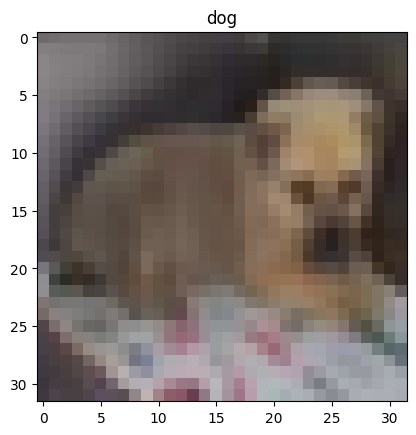

In [26]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

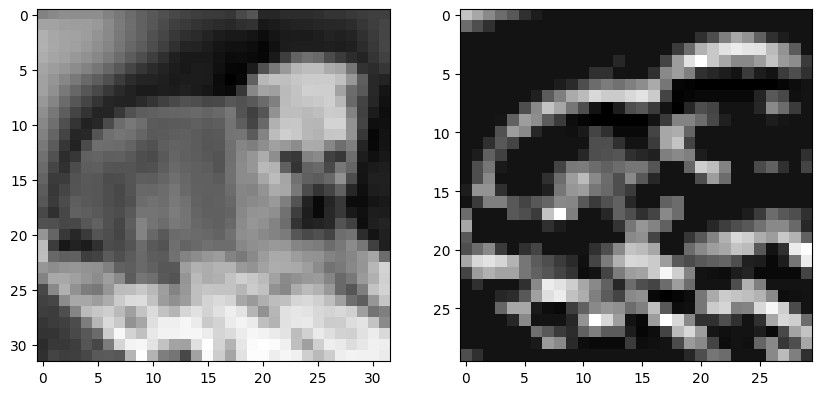

In [27]:
import numpy as np
import scipy.signal
from skimage import color
from skimage import exposure

img = color.rgb2gray(img)

kernel = np.array([[1,1,1],
                   [0,0,0],
                   [-1,-1,-1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

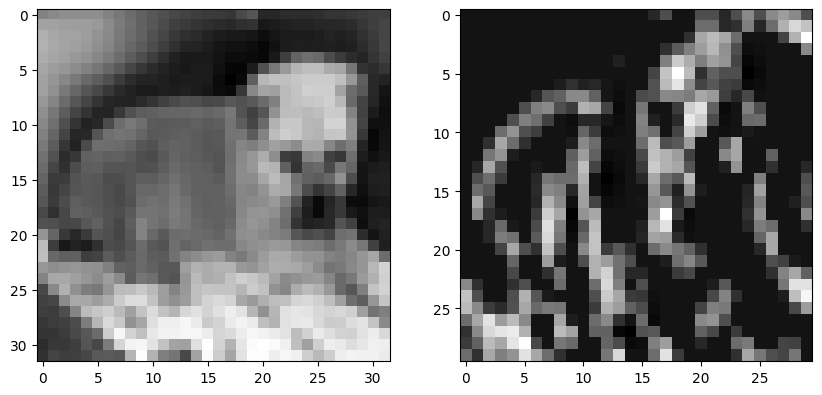

In [28]:
kernel = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

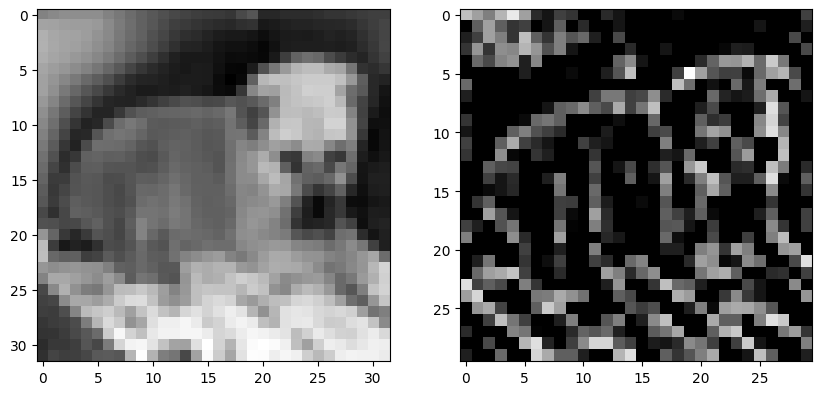

In [29]:
kernel = np.array([[0,-1,0],
                   [-1,4,-1],
                   [0,-1,0]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

En Pytorch

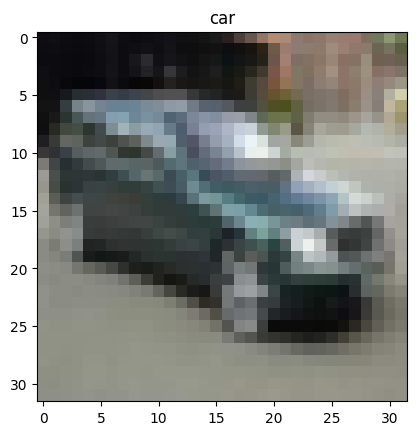

In [48]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [49]:
# convertir la imágen en tensor con dimensiones (N, C_in, H, W)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0)
img_tensor = img_tensor.permute(0, 3, 1, 2).float()

img_tensor.shape, img_tensor.dtype

(torch.Size([1, 3, 32, 32]), torch.float32)

In [50]:
# aplicamos 10 filtros de tamaño 3x3

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 30, 30])

In [51]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1, stride = 1)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 32, 32])

In [52]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 16, 16])

Pooling

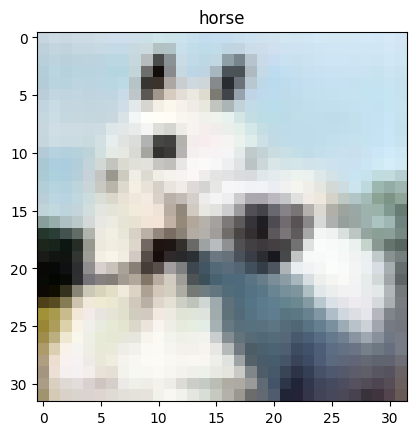

In [59]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [60]:
pool = torch.nn.MaxPool2d(3, padding=1, stride=2)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0).permute(0, 3, 1, 2).float()
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 16, 16])

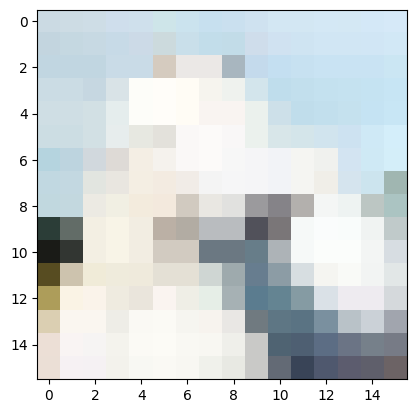

In [61]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

Redes convolucionales

In [62]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [63]:
model = CNN()

output = model(torch.randn(64, 1, 28, 28))

Dimensiones:
Entrada:  torch.Size([64, 1, 28, 28])
conv1:  torch.Size([64, 64, 14, 14])
conv2:  torch.Size([64, 128, 7, 7])
pre fc:  torch.Size([64, 6272])
Salida:  torch.Size([64, 10])


In [64]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [65]:
class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, Y):
		self.X = torch.tensor(X).float()
		self.Y = torch.tensor(Y).long()

	def __len__(self):
		return len(self.X)

	# devolvemos las imágenes con dimensiones (C, H, W)
	def __getitem__(self, ix):
		return self.X[ix].reshape(1, 28, 28), self.Y[ix]

In [66]:
model = CNN()

train(model)

epoch: 1/5
loss: 2.3044 [ 1000/60000]
loss: 0.8479 [11000/60000]
loss: 0.4415 [21000/60000]
loss: 0.4343 [31000/60000]
loss: 0.2665 [41000/60000]
loss: 0.1859 [51000/60000]
val_loss: 0.1831 val_acc: 0.9476
epoch: 2/5
loss: 0.2427 [ 1000/60000]
loss: 0.1386 [11000/60000]
loss: 0.1548 [21000/60000]
loss: 0.1163 [31000/60000]
loss: 0.1108 [41000/60000]
loss: 0.1588 [51000/60000]
val_loss: 0.0866 val_acc: 0.9760
epoch: 3/5
loss: 0.0810 [ 1000/60000]
loss: 0.0834 [11000/60000]
loss: 0.0704 [21000/60000]
loss: 0.0703 [31000/60000]
loss: 0.0896 [41000/60000]
loss: 0.0801 [51000/60000]
val_loss: 0.0593 val_acc: 0.9816
epoch: 4/5
loss: 0.0596 [ 1000/60000]
loss: 0.0607 [11000/60000]
loss: 0.0495 [21000/60000]
loss: 0.0924 [31000/60000]
loss: 0.0444 [41000/60000]
loss: 0.0718 [51000/60000]
val_loss: 0.0509 val_acc: 0.9827
epoch: 5/5
loss: 0.0426 [ 1000/60000]
loss: 0.0490 [11000/60000]
loss: 0.0467 [21000/60000]
loss: 0.0371 [31000/60000]
loss: 0.0467 [41000/60000]
loss: 0.0473 [51000/60000]
val

Arquitecturas

LeNet-5 (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

![](pics/lenet5.png)

In [68]:
import torch

def block(c_in, c_out, k=3, p=1, s=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.Tanh(),
        torch.nn.AvgPool2d(2, stride=2)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class LeNet5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    #self.pad = torch.nn.ConstantPad2d(2, 0.)
    self.conv1 = block(n_channels, 6, 5, p=0)
    self.conv2 = block(6, 16, 5, p=0)
    self.conv3 = torch.nn.Sequential(
        torch.nn.Conv2d(16, 120, 5, padding=0),
        torch.nn.Tanh()
    )
    self.fc1 = block2(120, 84)
    self.fc2 = torch.nn.Linear(84, 10)

  def forward(self, x):
    #x = self.pad(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [69]:
lenet5 = LeNet5()
output = lenet5(torch.randn(64, 1, 32, 32))
output.shape

torch.Size([64, 10])

Alexnet (https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

![](pics/alexnet.png)

In [70]:
import torchvision

alexnet = torchvision.models.AlexNet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [71]:
output = alexnet(torch.randn(64, 3, 224, 224))
output.shape

torch.Size([64, 1000])

VGG (https://arxiv.org/abs/1409.1556)

![](pics/vgg.png)

In [72]:
# existen dos variantes: vgg16 y vgg19, con 16 y 19 capas respectivamente

vgg16 = torchvision.models.vgg16()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [73]:
output = vgg16(torch.randn(64, 3, 224, 224))
output.shape

torch.Size([64, 1000])

ResNet (https://arxiv.org/abs/1512.03385)

![](pics/resnet.png)



In [74]:
# existen múltiples variantes: resnet18, resnet35, resnet50, resnet101, resnet152

resnet34 = torchvision.models.resnet34()
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
output = resnet34(torch.randn(64, 3, 224, 224))
output.shape

torch.Size([64, 1000])

Otras arquitecturas (https://huggingface.co/docs/timm)

## Transformers

In [76]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)

In [77]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.from_numpy(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()

In [78]:
attn_dm = Dataset(X, Y)
imgs, labels = attn_dm[0]
imgs.shape, labels.shape

(torch.Size([16, 49]), torch.Size([]))

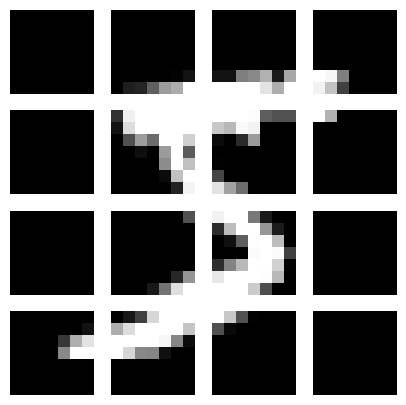

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
plt.show()

In [81]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

import math

class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values
        k = self.key(x) # (B, L, F)
        q = self.query(x) # (B, L, F)
        v = self.value(x) # (B, L, F)

        # attention (B, L, F) x (B, F, L) -> (B, L, L)
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, L, L) x (B, L, F) -> (B, L, F)

        return y

class Model(torch.nn.Module):

    def __init__(self, n_embd=7*7, seq_len=4*4):
        super().__init__()
        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        return y

In [82]:
model = Model()

train(model)

epoch: 1/5
loss: 60.6897 [ 1000/60000]
loss: 22.2778 [11000/60000]
loss: 10.8978 [21000/60000]
loss: 7.9166 [31000/60000]
loss: 6.0623 [41000/60000]
loss: 4.7374 [51000/60000]
val_loss: 4.0040 val_acc: 0.5165
epoch: 2/5
loss: 3.8141 [ 1000/60000]
loss: 3.8517 [11000/60000]
loss: 2.8660 [21000/60000]
loss: 2.8340 [31000/60000]
loss: 2.2559 [41000/60000]
loss: 2.3226 [51000/60000]
val_loss: 2.0592 val_acc: 0.6177
epoch: 3/5
loss: 1.9413 [ 1000/60000]
loss: 1.6784 [11000/60000]
loss: 1.8232 [21000/60000]
loss: 1.8378 [31000/60000]
loss: 1.6102 [41000/60000]
loss: 1.5846 [51000/60000]
val_loss: 1.4342 val_acc: 0.6696
epoch: 4/5
loss: 1.3847 [ 1000/60000]
loss: 1.2174 [11000/60000]
loss: 1.1866 [21000/60000]
loss: 1.2515 [31000/60000]
loss: 1.2603 [41000/60000]
loss: 1.2067 [51000/60000]
val_loss: 1.1392 val_acc: 0.6982
epoch: 5/5
loss: 1.0622 [ 1000/60000]
loss: 1.1236 [11000/60000]
loss: 1.1433 [21000/60000]
loss: 1.0811 [31000/60000]
loss: 1.1436 [41000/60000]
loss: 0.9909 [51000/60000]


In [83]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class Model(torch.nn.Module):

    def __init__(self, n_embd=7*7, seq_len=4*4, n_heads=4*4):
        super().__init__()
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        return y

In [84]:
model = Model()

train(model)

epoch: 1/5
loss: 18.2546 [ 1000/60000]
loss: 2.5113 [11000/60000]
loss: 1.6591 [21000/60000]
loss: 1.1678 [31000/60000]
loss: 1.0534 [41000/60000]
loss: 0.9509 [51000/60000]
val_loss: 0.6905 val_acc: 0.8848
epoch: 2/5
loss: 0.7470 [ 1000/60000]
loss: 0.5239 [11000/60000]
loss: 0.4526 [21000/60000]
loss: 0.5891 [31000/60000]
loss: 0.5377 [41000/60000]
loss: 0.3979 [51000/60000]
val_loss: 0.4282 val_acc: 0.9073
epoch: 3/5
loss: 0.2777 [ 1000/60000]
loss: 0.2669 [11000/60000]
loss: 0.2980 [21000/60000]
loss: 0.3470 [31000/60000]
loss: 0.2692 [41000/60000]
loss: 0.2441 [51000/60000]
val_loss: 0.3171 val_acc: 0.9225
epoch: 4/5
loss: 0.1871 [ 1000/60000]
loss: 0.1877 [11000/60000]
loss: 0.1689 [21000/60000]
loss: 0.2017 [31000/60000]
loss: 0.1581 [41000/60000]
loss: 0.1855 [51000/60000]
val_loss: 0.2756 val_acc: 0.9285
epoch: 5/5
loss: 0.1779 [ 1000/60000]
loss: 0.1488 [11000/60000]
loss: 0.1408 [21000/60000]
loss: 0.0985 [31000/60000]
loss: 0.1758 [41000/60000]
loss: 0.1580 [51000/60000]
va

Transformer Encoder

In [85]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.mlp(x))
        return x

class Model(torch.nn.Module):

    def __init__(self, n_input=7*7, n_embd=7*7, seq_len=4*4, n_heads=4*4, n_layers=1):
        super().__init__()
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(e)
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y

In [86]:
model = Model()

train(model)

epoch: 1/5
loss: 2.4921 [ 1000/60000]
loss: 0.7199 [11000/60000]
loss: 0.4041 [21000/60000]
loss: 0.3327 [31000/60000]
loss: 0.2922 [41000/60000]
loss: 0.2709 [51000/60000]
val_loss: 0.2254 val_acc: 0.9348
epoch: 2/5
loss: 0.2100 [ 1000/60000]
loss: 0.2117 [11000/60000]
loss: 0.1903 [21000/60000]
loss: 0.1858 [31000/60000]
loss: 0.1801 [41000/60000]
loss: 0.1730 [51000/60000]
val_loss: 0.1669 val_acc: 0.9510
epoch: 3/5
loss: 0.1609 [ 1000/60000]
loss: 0.1561 [11000/60000]
loss: 0.1475 [21000/60000]
loss: 0.1232 [31000/60000]
loss: 0.1448 [41000/60000]
loss: 0.1305 [51000/60000]
val_loss: 0.1402 val_acc: 0.9558
epoch: 4/5
loss: 0.0876 [ 1000/60000]
loss: 0.1341 [11000/60000]
loss: 0.1393 [21000/60000]
loss: 0.1153 [31000/60000]
loss: 0.1040 [41000/60000]
loss: 0.1025 [51000/60000]
val_loss: 0.1192 val_acc: 0.9623
epoch: 5/5
loss: 0.1036 [ 1000/60000]
loss: 0.1041 [11000/60000]
loss: 0.1250 [21000/60000]
loss: 0.1192 [31000/60000]
loss: 0.1257 [41000/60000]
loss: 0.0828 [51000/60000]
val

Encoder-Decoder

In [87]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)

In [88]:
vocab = 'abcdefghijklmnopqrstuvwxyz'
len_vocab = len(vocab) + 3

def number2caption(ix):
    if ix == 0: return 'cero'
    if ix == 1: return 'uno'
    if ix == 2: return 'dos'
    if ix == 3: return 'tres'
    if ix == 4: return 'cuatro'
    if ix == 5: return 'cinco'
    if ix == 6: return 'seis'
    if ix == 7: return 'siete'
    if ix == 8: return 'ocho'
    if ix == 9: return 'nueve'

def caption2ixs(caption):
    return [vocab.index(c) + 3 for c in caption]

def ixs2caption(ixs):
    return ('').join([vocab[ix - 3] for ix in ixs if ix not in [0, 1, 2]])

In [89]:
captions = [number2caption(ix) for ix in Y]

# cada letra tiene su número (índice en el vocab)
encoded = [[1] + caption2ixs(caption) + [2] for caption in captions] 

captions[:3], encoded[:3]

(['cinco', 'cero', 'cuatro'],
 [[1, 5, 11, 16, 5, 17, 2],
  [1, 5, 7, 20, 17, 2],
  [1, 5, 23, 3, 22, 20, 17, 2]])

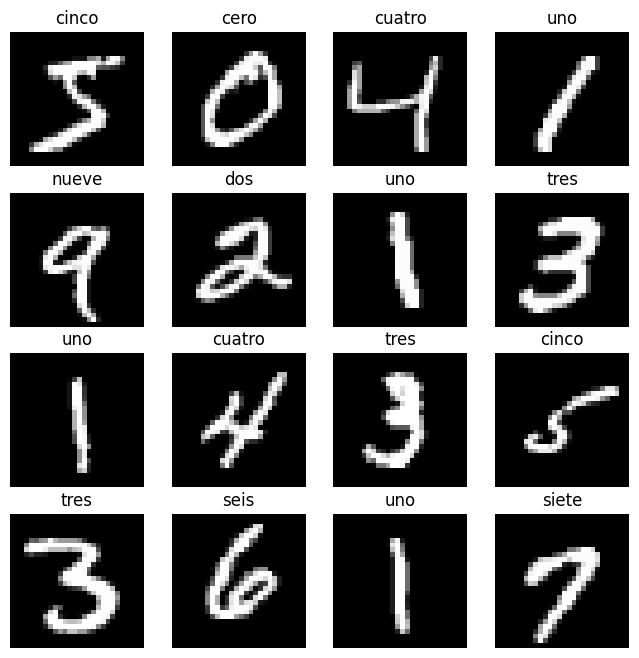

In [91]:
import matplotlib.pyplot as plt

r, c = 4, 4
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = X[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(caption)
plt.show()

In [92]:
import torch 

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.from_numpy(self.X[ix]).float().view(1, 28, 28) 
    return image, torch.tensor(self.y[ix]).long()

In [93]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [94]:
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self,
                 len_vocab,
                 img_size=28,
                 patch_size=7,
                 in_chans=1,
                 embed_dim=100,
                 max_len=8,
                 nhead=2,
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                ):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))

        self.trg_emb = nn.Embedding(len_vocab, embed_dim)
        self.trg_pos_emb = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len

        self.transformer = torch.nn.Transformer(
            embed_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout
        )

        self.l = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, len_vocab)

    def forward(self, images, captions):
        # embed images
        embed_imgs = self.patch_embed(images)
        embed_imgs = embed_imgs + self.pos_embed  # (B, N, E)
        # embed captions
        B, trg_seq_len = captions.shape
        trg_positions = (torch.arange(0, trg_seq_len).expand(B, trg_seq_len).to(images.device))
        embed_trg = self.trg_emb(captions) + self.trg_pos_emb(trg_positions)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(images.device)
        tgt_padding_mask = captions == 0
        # transformer
        y = self.transformer(
            embed_imgs.permute(1,0,2),  # S, B, E
            embed_trg.permute(1,0,2),  # T, B, E
            tgt_mask=trg_mask, # T, T
            tgt_key_padding_mask = tgt_padding_mask
        ).permute(1,0,2) # B, T, E
        # head
        return self.fc(self.l(y))

    def predict(self, image, device):
        self.eval()
        self.to(device)
        with torch.no_grad():
            image = image.to(device)
            B = 1
            # start of sentence
            eos = torch.tensor([1], dtype=torch.long, device=device).expand(B, 1)
            trg_input = eos
            for _ in range(self.max_len):
                preds = self(image.unsqueeze(0), trg_input)
                preds = torch.argmax(preds, axis=2)
                trg_input = torch.cat([eos, preds], 1)
            return preds

In [95]:
MAX_LEN = 8

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = [torch.nn.functional.pad(caption, (0, MAX_LEN - len(caption)), value=0) for caption in captions]
    captions = torch.stack(captions)
    return images, captions

In [96]:
def train(model, epochs=5, batch_size=1000):
	dataset = {
		"train": Dataset(X[:60000], encoded[:60000]), # 60.000 imágenes para entrenamiento
		"val": Dataset(X[60000:], encoded[60000:])    # 10.000 imágenes para validación
	}
	dataloader = {
		'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn),
		'val': torch.utils.data.DataLoader(dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True, collate_fn=collate_fn)
	}
	model.cuda()
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters())
	for e in range(1, epochs+1):
		print(f"epoch: {e}/{epochs}")
		# entrenamiento
		model.train()
		for batch_ix, (x, y) in enumerate(dataloader['train']):
			x, y = x.cuda(), y.cuda()
			optimizer.zero_grad()
			outputs = model(x, y[:,:-1])
			loss = criterion(outputs.permute(0,2,1), y[:,1:])
			loss.backward()
			optimizer.step()
			if batch_ix % 10 == 0:
				loss, current = loss.item(), (batch_ix + 1) * len(x)
				print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset['train']):>5d}]")
		# validación
		model.eval()
		val_loss, val_acc = [], []
		with torch.no_grad():
			for batch_ix, (x, y) in enumerate(dataloader['val']):
				x, y = x.cuda(), y.cuda()
				outputs = model(x, y[:,:-1])
				loss = criterion(outputs.permute(0,2,1), y[:,1:])
				val_loss.append(loss.item())
				acc = (torch.argmax(outputs, axis=2) == y[:,1:]).sum().item() / (y[:,1:].shape[0]*y[:,1:].shape[1])
				val_acc.append(acc)
		print(f"val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")

In [97]:
model = Model(len(vocab) + 3, max_len=MAX_LEN)

train(model)

epoch: 1/5


/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


loss: 3.4262 [ 1000/60000]
loss: 1.4203 [11000/60000]
loss: 0.6924 [21000/60000]
loss: 0.4580 [31000/60000]
loss: 0.3656 [41000/60000]
loss: 0.3198 [51000/60000]
val_loss: 0.2481 val_acc: 0.9134
epoch: 2/5
loss: 0.2766 [ 1000/60000]
loss: 0.2483 [11000/60000]
loss: 0.2392 [21000/60000]
loss: 0.2235 [31000/60000]
loss: 0.2051 [41000/60000]
loss: 0.1842 [51000/60000]
val_loss: 0.1575 val_acc: 0.9435
epoch: 3/5
loss: 0.1712 [ 1000/60000]
loss: 0.1580 [11000/60000]
loss: 0.1489 [21000/60000]
loss: 0.1357 [31000/60000]
loss: 0.1264 [41000/60000]
loss: 0.1257 [51000/60000]
val_loss: 0.0961 val_acc: 0.9676
epoch: 4/5
loss: 0.1201 [ 1000/60000]
loss: 0.0998 [11000/60000]
loss: 0.1043 [21000/60000]
loss: 0.1013 [31000/60000]
loss: 0.1001 [41000/60000]
loss: 0.0945 [51000/60000]
val_loss: 0.0800 val_acc: 0.9731
epoch: 5/5
loss: 0.0921 [ 1000/60000]
loss: 0.0884 [11000/60000]
loss: 0.0914 [21000/60000]
loss: 0.0853 [31000/60000]
loss: 0.0718 [41000/60000]
loss: 0.0763 [51000/60000]
val_loss: 0.05

/home/juan/miniconda3/envs/pt/lib/python3.11/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


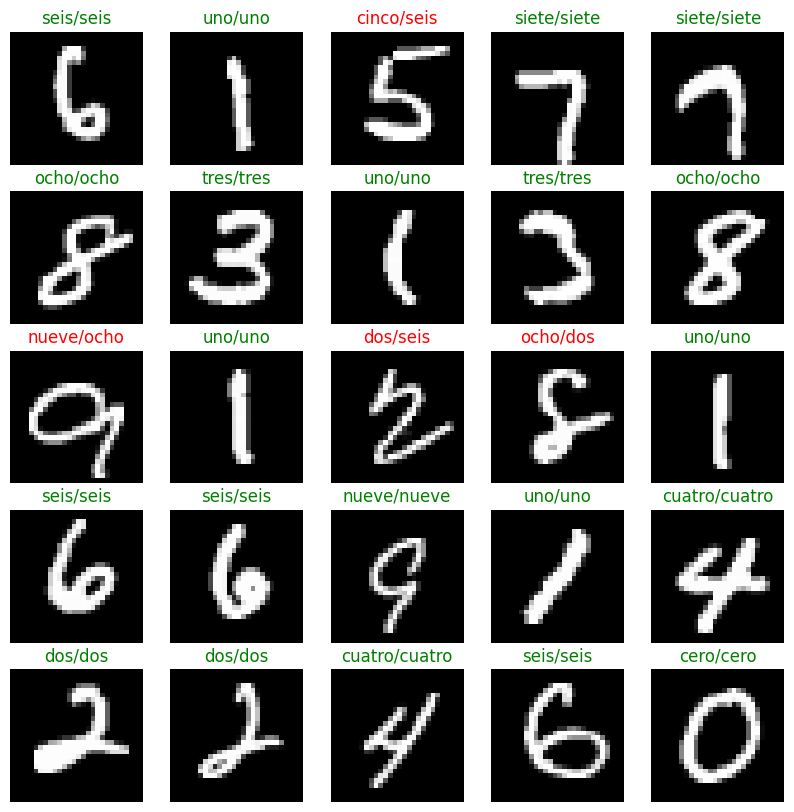

In [99]:
import random

r, c = 5,5
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        # ix = _r*c + _c
        ix = random.randint(0, len(X))
        ax = plt.subplot(r, c, _r*c + _c + 1)
        img, caption = torch.from_numpy(X[ix]).float().view(1, 28, 28), captions[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        pred = model.predict(img, device='cuda')
        pred = ixs2caption(pred.squeeze().tolist())
        ax.set_title(f'{caption}/{pred}', color="green" if caption == pred else 'red')
plt.show()